In [1]:
import os
import time
import datetime

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer, Truth
from tensorflow_probability.substrates.jax.distributions import Distribution

from configs import (
    cumulants_config, get_results_dir, get_posteriors_dir, 
    get_cumulants_sbi_args, get_ndes_from_config
)
from cumulants import (
    Dataset, get_data, get_prior, 
    get_compression_fn, get_datavector, get_linearised_data
)

from sbiax.utils import make_df, marker
from sbiax.ndes import Scaler, Ensemble, CNF, MAF 
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

from affine import affine_sample
from utils import plot_moments, plot_latin_moments, plot_summaries, plot_fisher_summaries

/Users/Jed.Homer/phd/sbiaxpdf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config

In [ ]:
t0 = time.time()

class Args:
    seed                = 0 #int(time.time())
    redshift            = 0.
    sbi_type            = "nle"
    linearised          = True
    reduced_cumulants   = True
    compression         = "linear"
    order_idx           = [0, 1, 2]
    pre_train           = False and (not linearised)
    n_linear_sims       = 10_000
    verbose             = False
    use_tqdm            = True

args = Args()

print("TIME:", datetime.datetime.now().strftime("%H:%M %d-%m-%y"))

config = cumulants_config(
    seed=args.seed, 
    redshift=args.redshift, 
    reduced_cumulants=args.reduced_cumulants,
    sbi_type=args.sbi_type,
    linearised=args.linearised, 
    compression=args.compression,
    order_idx=args.order_idx,
    n_linear_sims=args.n_linear_sims,
    pre_train=args.pre_train
)

key = jr.key(config.seed)

( 
    model_key, train_key, key_prior, 
    key_datavector, key_state, key_sample
) = jr.split(key, 6)

results_dir = get_results_dir(config, args)

posteriors_dir = get_posteriors_dir(config)

# Dataset of simulations, parameters, covariance, ...
dataset: Dataset = get_data(config, verbose=args.verbose, results_dir=results_dir)

print("DATA:", ["{:.3E} {:.3E}".format(_.min(), _.max()) for _ in (dataset.fiducial_data, dataset.data)])
print("DATA:", [_.shape for _ in (dataset.fiducial_data, dataset.data)])

parameter_prior: Distribution = get_prior(config)

TIME: 13:38 13-03-25
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/reduced_cumulants/nle/linearised/linear/z=0.0_m=012/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/results/posteriors/reduced_cumulants/nle/linearised/linear/z=0.0_m=012/0/
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 21) (10000, 5)
DATA: ['5.060E-02 1.041E+02', '-1.376E+03 1.233E+03']
DATA: [(15000, 21), (10000, 21)]
Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 21) (10000, 5)
Using flat prior


Compression

Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 21) (10000, 5)


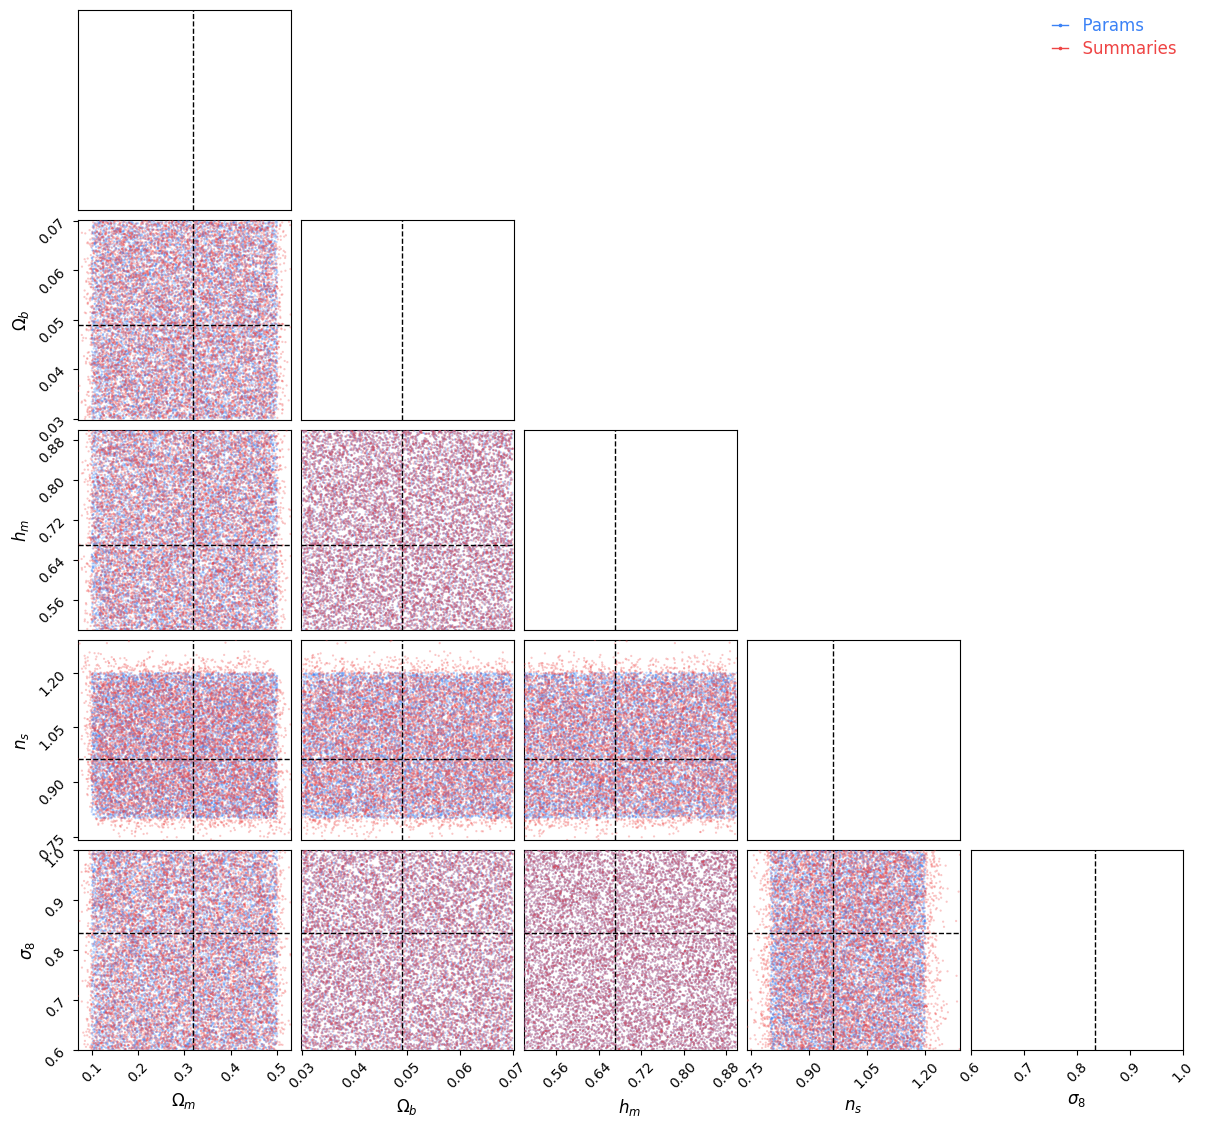

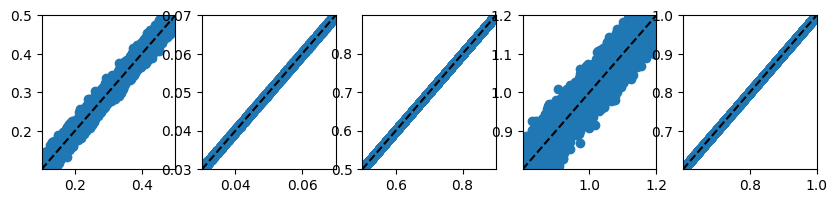

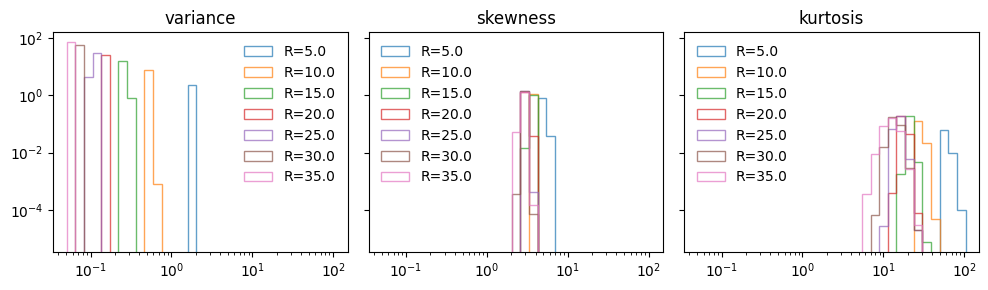

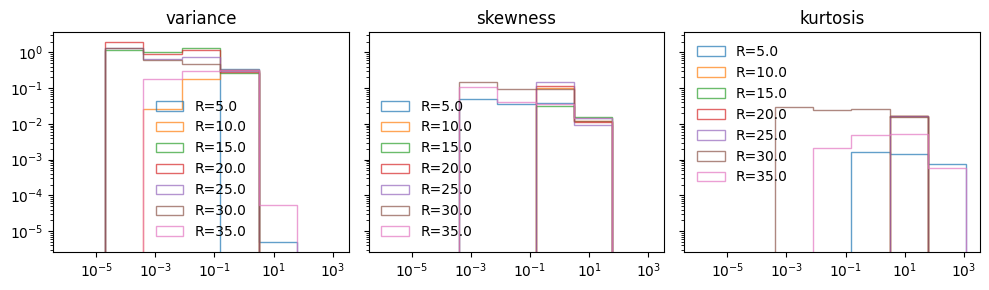

In [ ]:
# Compress simulations
compression_fn = get_compression_fn(key, config, dataset, results_dir=results_dir)

X = jax.vmap(compression_fn)(dataset.data, dataset.parameters)

# Plot summaries
plot_summaries(X, dataset.parameters, dataset)

plot_moments(dataset.fiducial_data, config)

plot_latin_moments(dataset.data, config)

NDEs

In [ ]:
scaler = Scaler(
    X, dataset.parameters, use_scaling=config.use_scaling
)

ndes = get_ndes_from_config(
    config, 
    event_dim=dataset.alpha.size, 
    scalers=scaler, # Same scaler for all NDEs 
    use_scalers=config.use_scalers, # NOTE: not to be trusted
    key=model_key
)

print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

data_preprocess_fn = lambda x: x #jnp.log(jnp.clip(x, min=1e-10))


scaler: [0.29993266 0.04999933 0.7000004  1.0001822  0.80000615]


In [5]:
# Only pre-train if required and not inferring from linear simulations
if (
    (not config.linearised) 
    and config.pre_train 
    and (config.n_linear_sims is not None)
):
    print("Linearised pre-training...")

    pre_train_key, summaries_key = jr.split(key)

    # Pre-train data = linearised simulations
    X_l, Y_l = get_linearised_data(config)
    X_l = jax.vmap(compression_fn)(X_l, Y_l)

    print("Pre-training with", X_l.shape, Y_l.shape)

    plot_fisher_summaries(X_l, Y_l, dataset, results_dir)

    opt = getattr(optax, config.pretrain.opt)(config.pretrain.lr)

    ensemble, stats = train_ensemble(
        pre_train_key, 
        ensemble,
        train_mode=config.sbi_type,
        train_data=(data_preprocess_fn(X_l), Y_l), 
        opt=opt,
        use_ema=config.use_ema,
        ema_rate=config.ema_rate,
        n_batch=config.pretrain.n_batch,
        patience=config.pretrain.patience,
        n_epochs=config.pretrain.n_epochs,
        valid_fraction=config.valid_fraction,
        tqdm_description="Training (pre-train)",
        show_tqdm=args.use_tqdm,
        results_dir=results_dir
    )

    datavector = get_datavector(key_datavector, config)

    x_ = compression_fn(datavector, dataset.alpha)

    log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

    state = jr.multivariate_normal(
        key_state, x_, dataset.Finv, (2 * config.n_walkers,)
    )

    samples, weights = affine_sample(
        key_sample, 
        log_prob=log_prob_fn,
        n_walkers=config.n_walkers, 
        n_steps=config.n_steps + config.burn, 
        burn=config.burn, 
        current_state=state,
        description="Sampling",
        show_tqdm=args.use_tqdm
    )

    samples_log_prob = jax.vmap(log_prob_fn)(samples)
    alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

    posterior_df = make_df(
        samples, 
        samples_log_prob, 
        parameter_strings=dataset.parameter_strings
    )

    np.savez(
        os.path.join(results_dir, "posterior.npz"), 
        alpha=dataset.alpha,
        samples=samples,
        samples_log_prob=samples_log_prob,
        datavector=datavector,
        summary=x_
    )

    c = ChainConsumer()
    c.add_chain(
        Chain.from_covariance(
            dataset.alpha,
            dataset.Finv,
            columns=dataset.parameter_strings,
            name=r"$F_{\Sigma^{-1}}$",
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
    c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
    c.add_marker(
        location=marker(x_, parameter_strings=dataset.parameter_strings),
        name=r"$\hat{x}$", 
        color="b"
    )
    c.add_marker(
        location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
        name=r"$\alpha$", 
        color="#7600bc"
    )
    fig = c.plotter.plot()
    plt.savefig(os.path.join(results_dir, "posterior_affine_pretrain.pdf"))
    plt.savefig(os.path.join(posteriors_dir, "posterior_affine_pretrain.pdf"))
    plt.close()

NDE on simulation

In [6]:
opt = getattr(optax, config.train.opt)(config.train.lr)

print("Data / Parameters", [_.shape for _ in (X, dataset.parameters)])

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=(data_preprocess_fn(X), dataset.parameters), 
    opt=opt,
    use_ema=config.use_ema,
    ema_rate=config.ema_rate,
    n_batch=config.train.n_batch,
    patience=config.train.patience,
    n_epochs=config.train.n_epochs,
    valid_fraction=config.valid_fraction,
    tqdm_description="Training (data)",
    show_tqdm=args.use_tqdm,
    results_dir=results_dir
)

print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

Data / Parameters [(10000, 5), (10000, 5)]
NDE has n_params=115.


Training terminated early at epoch 2283; valid=-3.059E+01, train=-3.045E+01.:  23%|██▎       | 2282/10000 [10:17<34:47,  3.70epoch/s, t=-3.045E+01 | v=-3.059E+01 | v(best)=-3.064E+01 | stop=0000]


Weights: [1.]
scaler: [0.29993266 0.04999933 0.7000004  1.0001822  0.80000615]


In [9]:
ensemble = eqx.nn.inference_mode(ensemble)

# Generates linearised (or not) datavector at fiducial parameters
datavector = get_datavector(key_datavector, config)

x_ = compression_fn(datavector, dataset.alpha)

print("datavector", x_, dataset.alpha)

log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

state = jr.multivariate_normal(
    key_state, x_, dataset.Finv, (2 * config.n_walkers,)
)

samples, weights = affine_sample(
    key_sample, 
    log_prob=log_prob_fn,
    n_walkers=config.n_walkers, 
    n_steps=config.n_steps + config.burn, 
    burn=config.burn, 
    current_state=state,
    description="Sampling",
    show_tqdm=args.use_tqdm
)

samples_log_prob = jax.vmap(log_prob_fn)(samples)
alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

np.savez(
    os.path.join(results_dir, "posterior.npz"), 
    alpha=dataset.alpha,
    samples=samples,
    samples_log_prob=samples_log_prob,
    datavector=datavector,
    summary=x_
)

Using linearised model, Gaussian noise.
Hypercube sampling...
Get linearised data (10000, 21) (10000, 5)
Using linearised datavector
datavector [0.3012622  0.04895135 0.6710924  0.99900854 0.83432657] [0.3175 0.049  0.6711 0.9624 0.834 ]


Sampling: 100%|██████████| 110/110 [00:34<00:00,  3.23it/s]


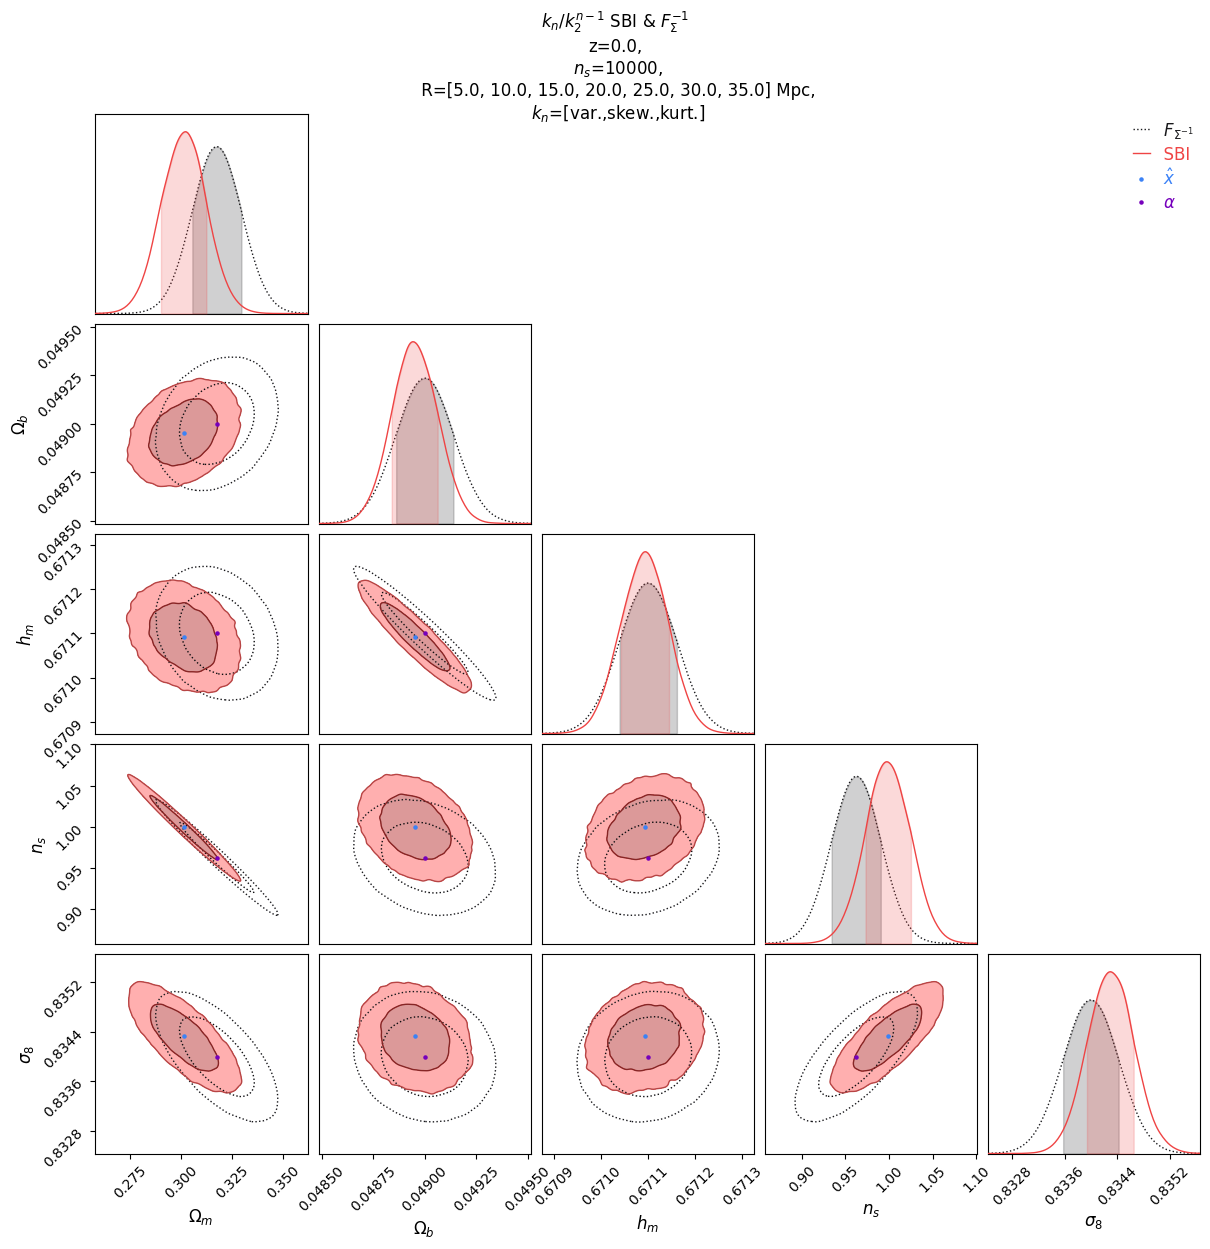

In [12]:
posterior_df = make_df(
    samples, 
    samples_log_prob, 
    parameter_strings=dataset.parameter_strings
)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        dataset.alpha,
        dataset.Finv,
        columns=dataset.parameter_strings,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
c.add_marker(
    location=marker(x_, parameter_strings=dataset.parameter_strings),
    name=r"$\hat{x}$", 
    color="b"
)
c.add_marker(
    location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"$k_n/k_2^{n-1}$ SBI & $F_{{\Sigma}}^{{-1}}$" + "\n" +
    "z={},\n $n_s$={},\n R={} Mpc,\n $k_n$={}".format(
        config.redshift, 
        config.n_linear_sims, 
        "[{}]".format(", ".join(map(str, config.scales))),
        "[{}]".format(",".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()
# plt.savefig(os.path.join(results_dir, "posterior_affine.pdf"))
# plt.savefig(os.path.join(posteriors_dir, "posterior_affine.pdf"))
# plt.close()